In [1]:
import torch
import torchvision as tv
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [3]:
%%bash

rm -rf .data
mkdir .data
unzip -q att-database-of-faces.zip -d .data/faces-training
cp -a .data/faces-training .data/faces-test

rm .data/faces-training/*/{1,2,3,4,5}.pgm
rm .data/faces-test/*/{6,7,8,9,10}.pgm

In [4]:
torch.manual_seed(1)

t = tv.transforms.Compose([
    tv.transforms.Grayscale(),
    tv.transforms.ToTensor()
])

# Load AT&T database of faces.
dataset = tv.datasets.ImageFolder(root=".data/faces-training", transform=t)


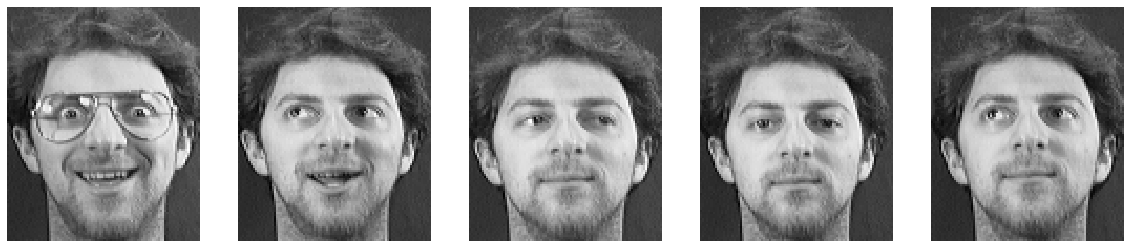

In [5]:
target_person = 37

all_images_of_target = [img for img, label in dataset if label == target_person]

_, ax = plt.subplots(1, len(all_images_of_target), figsize=(20, 5))
    
for p, img in zip(ax, all_images_of_target):
    p.imshow(img.squeeze(), cmap="gray")
    p.axis("off")

plt.show()

In [6]:
nc = 40
nf = 112 * 92

model = torch.nn.Linear(nf, nc)

opt = torch.optim.SGD(model.parameters(), lr=0.1)

criterion = torch.nn.CrossEntropyLoss()

0 29.91672992706299
1 76.2345962524414
2 104.84674224853515
3 85.55857048034667
4 58.08628349304199
5 47.15380783081055
6 32.4675274848938
7 27.145708274841308
8 12.774519729614259
9 18.23546094894409
10 19.80481014251709
11 8.376750445365905
12 4.044390839338303
13 0.7375148927079863
14 0.012281291908584535
15 0.024171907891286537
16 0.002859362555318512
17 0.0017660256125964224
18 0.0010233336739474907
19 0.0008826806879369542


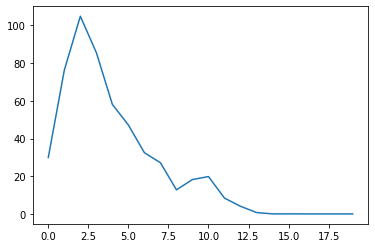

In [7]:
loader = torch.utils.data.DataLoader(dataset, batch_size=20, shuffle=True)

n_epochs = 20
cost = []

for i in range(n_epochs):
    l = 0
    n = 0
    for img, labels in loader:
        img = img.view(-1, nf)  # from [nbatches, 1, 112, 92] to [nbatches, 10304]
        output = model(img)
        opt.zero_grad()
        loss = criterion(output, labels)
        loss.backward()
        
        #########################################################
        # Enable the following lines to get more privacy.
        #########################################################
        #rnd = torch.distributions.normal.Normal(0.0, 1.0)
        #for p in model.parameters():
        #    p.grad += rnd.sample(torch.Size(p.grad.shape)) * 0.3
        #########################################################
        
        opt.step()
        l += loss.item()
        n += 1
    print(i, l/n)
    cost.append(l/n)
        
plt.plot(cost)
plt.show()

In [8]:
dataset = tv.datasets.ImageFolder(root=".data/faces-test", transform=t)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=200, shuffle=True)

with torch.no_grad():
    img, labels = iter(test_loader).next()
    r = model(img.view(-1, nf))
    p = r.argmax(dim=1)
    print("images:", len(labels))
    print("accuracy:", (labels == p).sum().item() / len(labels))


images: 200
accuracy: 0.9


In [9]:
import torch.nn.functional as F

x = torch.zeros(nf, requires_grad=True)
o = torch.optim.SGD([x], lr=0.1)

for i in range(1000):
    scores = F.softmax(model(x.view(1, nf)), dim=1).squeeze()
    e = torch.tensor([1.0]) - scores[target_person] # error for the target label
    o.zero_grad()
    e.backward()
    o.step()
    
x

tensor([-0.0809, -0.0723, -0.0528,  ..., -0.0076, -0.0047, -0.0078],
       requires_grad=True)

In [10]:
r = F.softmax(model(x), dim=0)
print("score of target person:", r[target_person].item())
print("scores:")
r

score of target person: 0.997209370136261
scores:


tensor([1.1723e-04, 1.2789e-04, 1.1470e-04, 4.9453e-05, 1.7667e-05, 6.2346e-05,
        4.2232e-05, 4.1894e-05, 1.4538e-04, 1.0721e-04, 5.8116e-05, 1.0599e-04,
        1.2335e-04, 5.6419e-05, 2.9280e-05, 2.7790e-04, 8.6045e-05, 2.3632e-06,
        2.4903e-05, 2.9471e-05, 4.3052e-05, 1.1357e-04, 4.2199e-05, 1.0386e-05,
        1.5544e-05, 1.6794e-04, 7.4970e-05, 2.6211e-05, 1.1674e-05, 3.4551e-04,
        8.2754e-05, 5.2562e-05, 9.8354e-06, 8.0387e-06, 3.4689e-05, 3.9958e-06,
        5.3851e-05, 9.9721e-01, 5.9918e-05, 1.4037e-05],
       grad_fn=<SoftmaxBackward>)

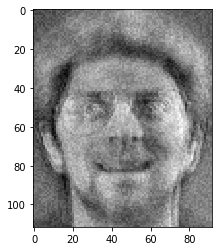

In [11]:
img = x.view(112, 92).detach()

plt.imshow(img, cmap="gray")
plt.show()